### Import the needed libraries

In [4]:
import warnings
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [23]:
def process_text_feature(data: pd.DataFrame, unique: list):
    """
    :param data: Pandas DataFrame - text feature (semi-structured)
    :param unique: List - unique code
    :return: Pandas DataFrame - processed codes
    """
    df = pd.DataFrame(columns=unique,
                           index=range(len(data)))

    for i in range(len(data)):
        text = data.code[i].split(',')

        for j in text:
            index_col = unique.index(j)
            df.loc[i][index_col] = 1

    df.fillna(0, inplace=True)

    return df

### Load data and Preprocessing

In [127]:
def preprocess_data():
    """
    Load and pre-process data.
    Implemented the following:
        - removed redundant variables
        - removed variables with high missing ratio
        - handle missing values by imputation
        - processed and incorporated the text codes columns
            - it was extended to multiple variables
        - One-hot encoded the categorical variables (ignored ordering)
        - implemented [0, 1] normalization

    :return: X_data, y_data
    """

    X_data = pd.read_csv("data.csv")
    y_data = X_data.class_label

    # removed redundant variables and the class label
    X_data.drop(["id", "date", "class_label"], axis=1, inplace=True)

    # - calculate % of missing values
    perc_missing = pd.DataFrame(
        {"perc_missing_values": X_data.isnull().mean() * 100}
    ).sort_values("perc_missing_values")

    perc_missing.query("perc_missing_values > 0", inplace=True)
    perc_missing

    perc_missing.iloc[:, 0].plot(
        kind="bar", title="% of missing values per variables", figsize=(15, 10)
    )

    # The following variables will be dropped,
    # because over 50% of them are missing X6 and K6
    X_data.drop(["X6", "K6"], axis=1, inplace=True)

    # Filling missing values by imputation via most_frequent
    imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    imputer.fit(X_data)
    X_data = pd.DataFrame(imputer.transform(X_data), columns=X_data.columns)

    # working on coded variable (semi structured in nature)
    code_data = pd.DataFrame(X_data.codes.values, columns=["code"])
    X_data.drop(["codes"], axis=1, inplace=True)
    code_unique = sorted(list(set(chain(*code_data.code.str.split(",").tolist()))))
    processed_codes = process_text_feature(code_data, code_unique)

    # One-hot encoding for the categorical variables
    cat_var = ["C1", "C2", "C3", "C4", "C5", "C6"]
    data_encode = X_data[cat_var]
    encoder = OneHotEncoder(handle_unknown="ignore")
    encoder.fit(data_encode)

    data_onehot = pd.DataFrame(
        encoder.transform(data_encode).toarray(),
        columns=encoder.get_feature_names()
    )

    # drop encoded variables from X_data and add data_onehot
    # and processed codes X_data to it
    X_data.drop(cat_var, axis=1, inplace=True)
    X_data = pd.concat([X_data, data_onehot, processed_codes], axis=1)

    scaler = MinMaxScaler()
    scaler.fit(X_data)
    X_data = scaler.fit_transform(X_data)

    return X_data, y_data

#### Environment Variables

In [114]:
MERIC_SCORING = 'roc_auc'
CV = 10

# Model Evaluation Metric:

ROC-AUC will be used to evaluate the models in this project. ROC is a curve (False Positive Rate vs Sensitivity) that show the ability of a binary classifier as its discrimination threshold is varied. While AUC is the area under the curve.

# <u> Working With Dataset

In [115]:
model_eval_df = pd.DataFrame(
    columns = ['model', 'optimal_param', 'testing_Accuracy'], 
    index=range(6)
)

(7413, 66)


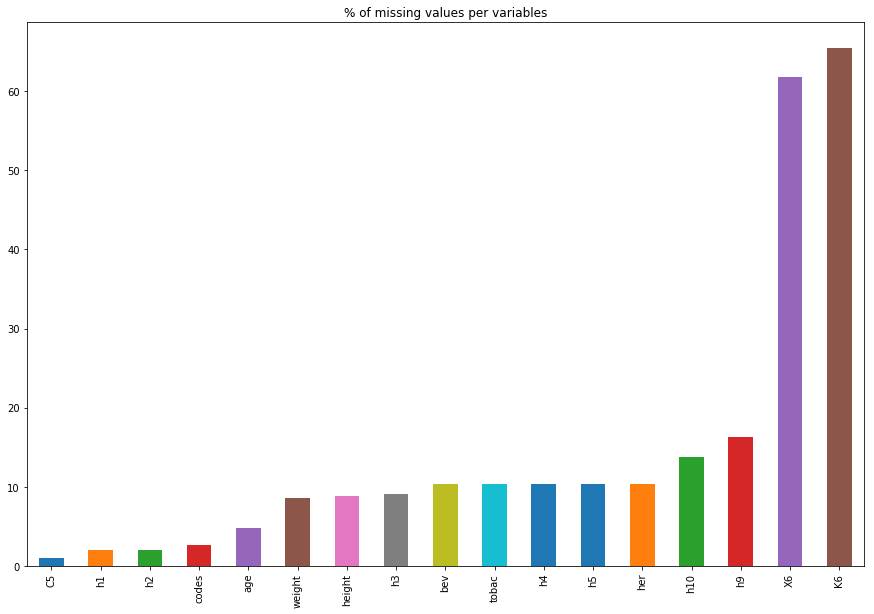

In [116]:
X_TRAIN, Y_TRAIN = preprocess_data()

### Distribution of the Class Label

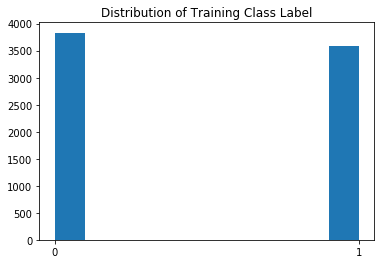

In [117]:
plt.hist(Y_TRAIN)
plt.xticks([0, 1])
plt.title('Distribution of Training Class Label')
plt.show()

### Divide Train set into Train and Test

In [118]:
X_TRAIN.shape

(7413, 66)

In [119]:
Y_TRAIN.shape

(7413,)

In [120]:
x_train, x_test, y_train, y_test = train_test_split(
    X_TRAIN, Y_TRAIN, test_size=0.12, random_state=42
)

# <u>1. Model: Naive Bayes

### (1a) Fitting the model 

In [121]:
nb_fit = GaussianNB().fit(x_train, y_train)

### (1b) Testing

In [122]:
nb_y_pred = nb_fit.predict(x_test)
nb_accuracy = round(metrics.accuracy_score(y_test, nb_y_pred), 4)
model_eval_df.loc[0] = ('Naive Bayes', '-', nb_accuracy)
print("Testing Accuracy = {}".format(nb_accuracy))

Testing Accuracy = 0.5258


### (1c) Confusion Matrix - Actual vs. Predicted

In [123]:
pd.DataFrame(metrics.confusion_matrix(y_test, nb_y_pred))

,0,1
0,58,404
1,18,410


# <u>2. Model: KNN

### (2a) Fitting the model with optimal Hyperparamters via Grid Search with 5-folds CV

In [29]:
k = np.arange(22, 27)
param_tune = {"n_neighbors": k}

knn = GridSearchCV(
    KNeighborsClassifier(), param_tune, cv=CV, scoring=MERIC_SCORING
)

knn.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([22, 23, 24, 25, 26])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### (2b) The optimal hyperparameters are:

In [64]:
model_eval_df.optimal_param[1] = 'k = {}'.format(*knn.best_params_.values())
print("k = {}".format(*knn.best_params_.values()))

k = 22


### (2c) Testing

In [65]:
knn_y_pred = knn.predict(x_test)
knn_accuracy = round(metrics.accuracy_score(y_test, knn_y_pred), 4)
model_eval_df.iloc[1, [0, 2]] = ('KNN', knn_accuracy)
print("Testing Accuracy = {}".format(knn_accuracy))

Testing Accuracy = 0.6243


### (2d) Confusion Matrix - Actual vs. Predicted

In [31]:
pd.DataFrame(metrics.confusion_matrix(y_test, knn_y_pred))

,0,1
0,697,376
1,318,456


# <u>3. Model: Logistic Regression - Ridge

### (3a) Fitting the model with optimal Hyperparamters via Grid Search with 5-folds CV

In [124]:
lg_cost = np.logspace(-1, 1, 3)
param_tune = {'C': lg_cost}

lg_regr = GridSearchCV(
    LogisticRegression(solver='lbfgs', max_iter=500), 
    param_tune, cv=CV, scoring=MERIC_SCORING
)

lg_regr.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([ 0.1,  1. , 10. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### (3b) The optimal hyperparameters are:

In [125]:
model_eval_df.optimal_param[2] = 'C = {}'.format(*lg_regr.best_params_.values())
print("C = {}".format(*lg_regr.best_params_.values()))

C = 1.0


### (3c) Testing

In [126]:
lg_regr_y_pred = lg_regr.predict(x_test)
lg_regr_accuracy = round(metrics.accuracy_score(y_test, lg_regr_y_pred), 4)
model_eval_df.iloc[2, [0, 2]] = ('Logistic Regression', lg_regr_accuracy)
print("Testing Accuracy = {}".format(lg_regr_accuracy))

Testing Accuracy = 0.6461


### (3d) Confusion Matrix - Actual vs. Predicted

In [48]:
pd.DataFrame(metrics.confusion_matrix(y_test, lg_regr_y_pred))

,0,1
0,761,312
1,297,477


# <u>4. Model: SVM - RBF Kernel

### (4a) Fitting the model with optimal Hyperparamters via Grid Search with 5-folds CV

In [49]:
svm_cost = np.logspace(-4, -3, 2)

param_tune = {'C': svm_cost}

svm = GridSearchCV(
    SVC(gamma='auto'), param_tune, cv=CV, scoring=MERIC_SCORING
)

svm.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([0.0001, 0.001 ])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

### (4b) The optimal hyperparameters are:

In [50]:
model_eval_df.optimal_param[3] = 'C = {}'.format(*svm.best_params_.values())
print("C = {}".format(*svm.best_params_.values()))

C = 0.0001


### (4c) Testing

In [51]:
svm_y_pred = svm.predict(x_test)
svm_accuracy = round(metrics.accuracy_score(y_test, svm_y_pred), 4)
model_eval_df.iloc[3, [0, 2]] = ('SVM', svm_accuracy)
print("Testing Accuracy = {}".format(svm_accuracy))

Testing Accuracy = 0.5809


### (4d) Confusion Matrix - Actual vs. Predicted

In [52]:
pd.DataFrame(metrics.confusion_matrix(y_test, svm_y_pred))

,0,1
0,1073,0
1,774,0


# <u>5. Model: Multi-layer Perceptron

### (5a) Fitting the model with optimal Hyperparamters via Grid Search with 5-folds CV

In [56]:
mp_alpha = np.logspace(-4, -3, 2) # l2 penalty
param_tune = {'alpha': mp_alpha}

mlp = GridSearchCV(
    MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=300), 
    param_tune, cv=CV, scoring=MERIC_SCORING
)

mlp.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(512, 256), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.0001, 0.001 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### (5b) The optimal hyperparameters are:

In [59]:
model_eval_df.optimal_param[4] = 'Alpha = {}'.format(*mlp.best_params_.values())
print("Alpha = {}".format(*mlp.best_params_.values()))

Alpha = 0.001


### (5c) Testing

In [61]:
mlp_y_pred = mlp.predict(x_test)
mlp_accuracy = round(metrics.accuracy_score(y_test, mlp_y_pred), 4)
model_eval_df.iloc[4, [0, 2]] = ('MLP', mlp_accuracy)
print("Testing Accuracy = {}".format(mlp_accuracy))

Testing Accuracy = 0.627


### (5d) Confusion Matrix - Actual vs. Predicted

In [62]:
pd.DataFrame(metrics.confusion_matrix(y_test, mlp_y_pred))

,0,1
0,748,325
1,364,410


# <u> Ensemble (with all the Models) by Voting

In [89]:
voting = VotingClassifier(
    estimators=[
        ('nb', nb_fit), 
        ('knn', knn), 
        ('lgr', lg_regr), 
        ('svm', svm), 
        ('mlp', mlp)
    ],
    voting='hard'
)

voting.fit(x_train, y_train)

VotingClassifier(estimators=[('nb', GaussianNB(priors=None, var_smoothing=1e-09)), ('knn', GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='..._dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [90]:
voting_y_pred = voting.predict(x_test)

In [93]:
voting_accuracy = round(metrics.accuracy_score(y_test, voting_y_pred), 4)
model_eval_df.loc[5] = ('Ensemble Voting', '-', voting_accuracy)
print("Testing Accuracy = {}".format(voting_accuracy))

Testing Accuracy = 0.6665


# <u> Summary

In [94]:
model_eval_df.sort_values('testing_Accuracy', ascending=False)

,model,optimal_param,testing_Accuracy
2,Logistic Regression,C = 1.0,0.6703
5,Ensemble Voting,-,0.6665
4,MLP,Alpha = 0.001,0.627
1,KNN,k = 22,0.6243
3,SVM,C = 0.0001,0.5809
0,Naive Bayes,-,0.5636
